In [56]:
from fastai import *
from fastai.tabular import *
from tqdm import tqdm_notebook as tqdm

In [2]:
path = Path('/home/anubhav/Downloads/Kaggle_Runs/HackerEarth_Airplane/')

In [3]:
path.ls()

[PosixPath('/home/anubhav/Downloads/Kaggle_Runs/HackerEarth_Airplane/test.csv'),
 PosixPath('/home/anubhav/Downloads/Kaggle_Runs/HackerEarth_Airplane/train.csv'),
 PosixPath('/home/anubhav/Downloads/Kaggle_Runs/HackerEarth_Airplane/sample_submission.csv')]

In [13]:
df = pd.read_csv(f'{path}/train.csv')
df_test = pd.read_csv(f'{path}/test.csv')
sample = pd.read_csv(f'{path}/sample_submission.csv')

In [17]:
df.drop('Accident_ID', axis=1, inplace=True)

In [18]:
df.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883


In [19]:
len(df), len(df.columns)

(10000, 11)

In [8]:
df['Severity'].nunique(), df['Days_Since_Inspection'].nunique(), df['Total_Safety_Complaints'].nunique()

(4, 23, 44)

In [10]:
df['Accident_Type_Code'].nunique(), df['Violations'].nunique()

(7, 6)

In [26]:
dep_var = 'Severity'

cat_names = ['Days_Since_Inspection', 'Total_Safety_Complaints', 'Accident_Type_Code', 'Violations']

cont_names = ['Safety_Score', 'Control_Metric', 'Turbulence_In_gforces',
              'Cabin_Temperature', 'Max_Elevation', 'Adverse_Weather_Metric']
procs = [FillMissing, Categorify, Normalize]

In [22]:
valid_idx=np.random.random_integers(0,10000,500)
valid_idx

/home/anubhav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 10000 + 1) instead
  """Entry point for launching an IPython kernel.


array([3662, 5290,  606, 8624, ..., 3155,   21, 3343, 2546])

In [24]:
test = TabularList.from_df(df_test, path=path, cat_names=cat_names, cont_names=cont_names)

In [27]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, procs=procs)
                           .split_by_idx(valid_idx)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch(bs=128))

In [29]:
# weights = [0.3, 0.7]
class_weights=torch.FloatTensor(weights)
class_weights

tensor([0.3000, 0.7000])

In [76]:
learn = tabular_learner(data, layers=[300, 300], emb_drop=0.04, ps=[0.001, 0.01], metrics=accuracy)

learn.loss_func = nn.CrossEntropyLoss()

In [77]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 9)
    (1): Embedding(45, 13)
    (2): Embedding(8, 5)
    (3): Embedding(7, 5)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=32, out_features=300, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=300, out_features=300, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=300, out_features=4, bias=True)
  )
)

In [78]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


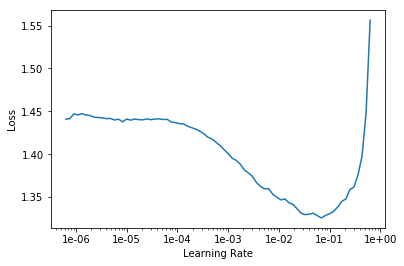

In [43]:
learn.recorder.plot()

In [80]:
learn.fit_one_cycle(2, 3e-05, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.020238,1.134552,0.540000,00:01
1,1.022389,1.134908,0.540000,00:01


# Prediction

In [50]:
sample.head()

,Accident_ID,Severity
0,1,Minor_Damage_And_Injuries
1,10,Highly_Fatal_And_Damaging
2,14,Highly_Fatal_And_Damaging
3,17,Significant_Damage_And_Serious_Injuries
4,21,Minor_Damage_And_Injuries


In [51]:
df_test.head()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,19.497717,16,6,72.151322,0.388959,78.32,4,37949.724386,2,0.069692,1
1,58.173516,15,3,64.585232,0.250841,78.60,7,30194.805567,2,0.002777,10
2,33.287671,15,3,64.721969,0.336669,86.96,6,17572.925484,1,0.004316,14
3,3.287671,21,5,66.362808,0.421775,80.86,3,40209.186341,2,0.199990,17
4,10.867580,18,2,56.107566,0.313228,79.22,2,35495.525408,2,0.483696,21


In [81]:
preds = learn.get_preds(DatasetType.Test)

In [82]:
preds

[tensor([[0.7067, 0.1182, 0.1276, 0.0475],
         [0.1523, 0.2781, 0.4098, 0.1598],
         [0.1294, 0.3433, 0.1053, 0.4220],
         ...,
         [0.1272, 0.0065, 0.0229, 0.8434],
         [0.1650, 0.2562, 0.0630, 0.5158],
         [0.4243, 0.3358, 0.0688, 0.1711]]), tensor([0, 0, 0,  ..., 0, 0, 0])]

In [83]:
data.train_ds.classes

['Highly_Fatal_And_Damaging',
 'Minor_Damage_And_Injuries',
 'Significant_Damage_And_Fatalities',
 'Significant_Damage_And_Serious_Injuries']

In [84]:
def get_submision(preds):
    labelled_preds = []
    pred11 = preds
    for pred in tqdm(pred11):
        labelled_preds.append(data.train_ds.classes[int(np.argmax(pred))])
    sub = pd.DataFrame({'Accident_ID':df_test.Accident_ID,
                       'Severity': labelled_preds})
#     sample['Severity'] = labelled_preds
    
    return sub

In [85]:
sub = get_submision(preds[0])

In [86]:
sub.reset_index(drop=True)

,Accident_ID,Severity
0,1,Highly_Fatal_And_Damaging
1,10,Significant_Damage_And_Fatalities
2,14,Significant_Damage_And_Serious_Injuries
3,17,Highly_Fatal_And_Damaging
4,21,Minor_Damage_And_Injuries
5,40,Highly_Fatal_And_Damaging
6,45,Significant_Damage_And_Fatalities
7,50,Highly_Fatal_And_Damaging
8,52,Highly_Fatal_And_Damaging
9,85,Significant_Damage_And_Serious_Injuries


In [87]:
sub.to_csv(f'{path}/HE_sub2.csv',index=False)